# Compute Sample Probing and Model Probing uncertainty for StrategyQA and Sports Understanding datasets

In [1]:
import pandas as pd
import numpy as np
import scipy
from sentence_transformers import CrossEncoder
from tqdm.notebook import tqdm as tqdm
import re
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /n/home13/stanneru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load a pre-trained transformer to measure entailment of steps in a chain of thought explanation

In [2]:
# Load pre-trained transformer model
model = CrossEncoder('cross-encoder/nli-deberta-v3-base')

/n/home13/stanneru/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [13]:
# file_path must be set to the output file path after running uncertainty-all.py script

# file_path = "data/strategyqa_100/output-text-davinci-003.parquet"
# file_path = "data/sportsunderstanding_100/output-gpt-3.5-turbo.parquet"
file_path = "data/sportsunderstanding_100/output-text-davinci-003.parquet"
data = pd.read_parquet(file_path)
data

,inputs,targets,multiple_choice_targets,multiple_choice_scores,idx,paraphrased_questions,experiment_1_question,experiment_2_question,experiment_3_question,experiment_4_question,experiment_5_question,experiment_8_question,experiment_9_question,experiment_1,experiment_2,experiment_3,experiment_4,experiment_5,experiment_8,experiment_9
140,Determine whether the following statement or s...,[plausible],"[plausible, implausible]","[1, 0]",140,"[Did Toni Kroos get called for offsides?, Was ...","\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...","[Read the question, and output the words impor...","\nRead the question, give your answer by analy...","Read the question, and output the words import...",\nStep 1: Check if Toni Kroos is a soccer play...,\n\n1. Toni\n2. Kroos\n3. Offsides\nFinal Answ...,"\nWord: Toni, Importance: 40\nWord: Kroos, Imp...",[\n\nThe Earth is flat.\n\nStep 1: The Earth i...,[\n\n1. Climate change is caused by human acti...,[\n\nStep 1: Toni Kroos is a professional socc...,[\n\n1. Toni\n2. Kroos\n3. Offsides\nFinal Ans...
113,Determine whether the following statement or s...,[plausible],"[plausible, implausible]","[1, 0]",113,"[Cale Makar was sent to the penalty box, Cale ...","\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...","[Read the question, and output the words impor...","\nRead the question, give your answer by analy...","Read the question, and output the words import...",\n\nStep 1: Cale Makar is a professional hocke...,\n\n1. Plausible\n2. Implausible\nFinal Answer...,"\nWord: Cale, Importance: 20\nWord: Makar, Imp...",[\n\nThe Earth is flat.\n\nStep 1: The Earth i...,[\n\n1. Human beings are capable of understand...,[\n\nStep 1: Research whether Cale Makar has r...,[\n1. Penalty\n2. Box\n3. Cale\n4. Makar\nFina...
16,Determine whether the following statement or s...,[plausible],"[plausible, implausible]","[1, 0]",16,"[-yard bo, , Wayne Rooney took a shot from out...","\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...","[Read the question, and output the words impor...","\nRead the question, give your answer by analy...","Read the question, and output the words import...",\n\nStep 1: Wayne Rooney is a professional soc...,\n\n1. Wayne\n2. Rooney\n3. Shot\n4. Outside\n...,"\nWord: Wayne, Importance: 10\nWord: Rooney, I...",[\n\nThe Earth is flat.\n\nStep 1: The Earth i...,[\n\n1. Human beings are capable of understand...,[\n\nStep 1: Determine whether shooting from o...,[\n\n1. Wayne\n2. Rooney\n3. Shot\n4. Outside\...
75,Determine whether the following statement or s...,[implausible],"[plausible, implausible]","[0, 1]",75,[Did Anders Lee go in studs up in the Champion...,"\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...","[Read the question, and output the words impor...","\nRead the question, give your answer by analy...","Read the question, and output the words import...",\n\nStep 1: Research whether Anders Lee was in...,\n\n1. Anders\n2. Lee\n3. Champions\n4. League...,"\nWord: Anders, Importance: 10\nWord: Lee, Imp...",[\nStep 1: Research Anders Lee's playing style...,[\n1. Anders\n2. Lee\n3. Champions\n4. League\...,[\nStep 1: Anders Lee is a professional ice ho...,[\n\n1. Anders\n2. Lee\n3. Champions\n4. Leagu...
155,Determine whether the following statement or s...,[implausible],"[plausible, implausible]","[0, 1]",155,"[goa, , Did Rhys Hoskins score a bicycle kick ...","\nRead the qu

## Define utility functions

In [14]:
def parse_verbalized_cot_explanation(answer):
    """
    Parse verbalized chain of thought explanation to steps and confidence scores from generated text
    """
    for pattern in ["Confidence: Low", "Confidence: Medium", "Confidence: High"]:
        if pattern in answer:
            answer = answer.replace(pattern, "Confidence: 100%")
    answer = answer[:answer.find("Final Answer and Overall Confidence")].strip()
    cot_steps = []
    for sentence in re.split("Step \d:", answer):
        # print(sentence)
        steps = re.split(r',|\n|\.', sentence)
        # print(steps)
        step = ". ".join(list(filter(lambda step: "confidence" not in step.lower(), steps)))
        confidence = None
        pattern = r'(\d{1,3})%'
        match = re.search(pattern, sentence)
        if match:
            # Extract and print the percentage value
            confidence = match.group(1)
        if len(sentence.strip()) > 0:
            if confidence is not None:
                cot_steps.append({
                    'step': step,
                    'confidence': int(confidence) / 100.0,
                })
    return cot_steps


def collate_cot_steps(cot_steps):
    """
    Combine all chain of thought steps into one reasoning step
    """
    return [
        {
            'step': ' '.join([cot_step['step'].strip() for cot_step in cot_steps]),
            'confidence': None
        }
    ]


def split_cot_steps(cot_steps):
    """
    Splits cot steps with multiple sentences into different individual steps
    """
    new_cot_steps = []
    for cot_step in cot_steps:
        text = cot_step["step"]
        text_list = nltk.tokenize.sent_tokenize(text)
        for text in text_list:
            new_cot_steps.append({'step': text, 'confidence': None})
    return new_cot_steps


def parse_verbalized_feature_importance_explanation(answer):
    """
    Parse verbalized feature importance explanation to important words and importance scores
    """
    feature_importances = {}
    for sentence in answer.split("\n"):
        if "Word: " in sentence and "Importance: " in sentence:
            pos = sentence.find("Importance: ")
            word, importance = sentence[:pos].strip().strip(','), sentence[pos:].strip().strip(',')
            word = word.strip().replace("Word: ", "")
            importance = importance.strip().replace("Importance: ", "")
            feature_importances[word.strip()] = float(importance.replace("%", "").strip()) / 100.0
    val_sum = 100
    feature_importances = {key.lower().strip(): val / val_sum for key, val in feature_importances.items() if val != 0}
    return feature_importances


def softmax(arr):
    """
    Softmax function
    """
    exp_arr = np.exp(arr)
    sum_exp_arr = np.sum(exp_arr)
    softmax_result = exp_arr / sum_exp_arr
    return softmax_result


def kl_divergence(p, q):
    """
    KL Divergence between p and q distributions
    """
    # Ensure that p and q are valid probability distributions
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p)
    q = q / np.sum(q)
    # Compute KL divergence
    kl = np.sum(p * np.log(p / q))
    return kl


def get_tvd_distance(feature_importance_explanation_1, feature_importance_explanation_2):
    """
    Get total variational distance between two feature importance explanation distributions
    """
    words = list(feature_importance_explanation_1.keys())
    if len(words) == 0:
        return 0
    dist = 0
    for word in words:
        dist += abs(feature_importance_explanation_1.get(word, 0) - feature_importance_explanation_2.get(word, 0))
    return dist


def parse_important_words_fi_response(fi_explanation):
    """
    Identify important words from generated feature importance explanation
    """
    sentences = fi_explanation.strip().lower().split("\n")
    words = []
    for sentence in sentences:
        if "answer" in sentence and ":" in sentence:
            continue
        match = re.match(r'^\d+\.', sentence.strip())
        if match is not None:
            word = sentence.strip()[match.end():]
            words.append(word.strip())
        elif "," in sentence:
            words.extend([word.strip() for word in sentence.split(",")])
    return words


def get_overall_feature_agreement(important_words_1, important_words_2, k=3):
    """
    Measure feature agreement between two token importance explanations
    """
    important_words_1 = set(list(map(lambda word: word.lower(), important_words_1[:k])))
    important_words_2 = set(list(map(lambda word: word.lower(), important_words_2[:k])))
    return len(important_words_1.intersection(important_words_2)) / k

def get_rank_feature_agreement(important_words_1, important_words_2, k=3):
    """
    Measure rank agreement between two token importance explanations
    """
    num = 0
    den = 0
    for word_1, word_2 in zip(important_words_1[:k], important_words_2[:k]):
        if word_1 == word_2:
            num += 1
        den += 1
    if den == 0:
        return None
    return num / den

## Define functions to parse explanations from generated text, and compute explanation uncertainty

In [15]:
def get_experiment_1_score(answer):
    """
    Multi-step verbalized confidence
    """
    cot_steps = parse_verbalized_cot_explanation(answer)
    score = 1.0
    for step in cot_steps:
        score *= step['confidence']
    return score


def get_experiment_2_score(answer):
    """
    Verbalized confidence
    """
    if len(re.findall(r'\bPlausible\b', answer, re.IGNORECASE)) > 0:
        return "Plausible"
    if len(re.findall(r'\bImplausible\b', answer, re.IGNORECASE)) > 0:
        return "Implausible"
    if len(re.findall(r'\bbImplausible\b', answer, re.IGNORECASE)) > 0:
        return "Implausible"
    print(answer)
    return None


def get_experiment_3_score(answer):
    """
    Verbalized confidence
    """
    answer = answer.split("\n")
    answer = list(filter(lambda ans: "Final Answer and Overall Confidence" in ans, answer))
    if len(answer) == 0:
        return None
    else:
        answer = answer[-1]
    pattern = r'(\d{1,3})%'
    match = re.search(pattern, answer)
    if match:
        # Extract and print the percentage value
        percentage_value = match.group(1)
    else:
        percentage_value = None
    return percentage_value


def get_entailment_score(text_1, text_2):
    """
    Measure entailment / agreement score between two statements.
    """
    scores = model.predict([(text_1, text_2)])
    scores = scipy.special.softmax(scores, axis=1)
    # Convert scores to labels
    label_mapping = ['contradiction', 'entailment', 'neutral']
    return scores[0][1]


def get_consistency_score(cot_explanation_1_steps, cot_explanation_2_steps):
    """
    Compute the agreement between two chain of thought explanations 
    """
    text_pairs = []
    for idx_1, step_1 in enumerate(cot_explanation_1_steps):
        for idx_2, step_2 in enumerate(cot_explanation_2_steps):
            text_pairs.append([step_1['step'], step_2['step']])
    try:
        scores = model.predict(text_pairs)
    except Exception as e:
        print(text_pairs)
        raise e
    scores = scipy.special.softmax(scores, axis=1)
    entailment_matrix = scores[:, 1].reshape((len(cot_explanation_1_steps), len(cot_explanation_2_steps)))
    # return scores
    consistency = (np.max(entailment_matrix, axis=1).sum() + np.max(entailment_matrix, axis=0).sum()) / (entailment_matrix.shape[0] + entailment_matrix.shape[1])
    return consistency


def get_experiment_4_score(original_cot_explanation, answers):
    """
    Compute CoT explanation confidence scores
    """
    original_cot_explanation = parse_verbalized_cot_explanation(original_cot_explanation)
    cot_steps_paraphrased = [parse_verbalized_cot_explanation(answer) for answer in answers]
    cot_steps_paraphrased = list(filter(lambda exp: len(exp) > 0, cot_steps_paraphrased))
    cot_steps_paraphrased = [split_cot_steps(cot_steps) for cot_steps in cot_steps_paraphrased]
    consistency = []
    for i in range(len(cot_steps_paraphrased)):
        if len(cot_steps_paraphrased[i]) == 0:
            continue
        consistency.append(get_consistency_score_bool(original_cot_explanation, cot_steps_paraphrased[i]))
    return np.mean(consistency)


def get_experiment_5_score(original_feature_importance_explanation, answers):
    """
    Compute token importance explanation confidence score
    """
    original_feature_importance_explanation = parse_verbalized_feature_importance_explanation(original_feature_importance_explanation)
    feature_importance_explanations = [parse_verbalized_feature_importance_explanation(feature_importance_explanation) for feature_importance_explanation in answers]
    tvd_distances = []
    for i in range(len(feature_importance_explanations)):
        tvd_distances.append(get_tvd_distance(original_feature_importance_explanation, feature_importance_explanations[i]))
        # tvd_distances.append(get_tvd_distance(original_feature_importance_explanation, feature_importance_explanations[i]))
    return 1 - np.mean(tvd_distances)

def get_experiment_5_score_new(original_feature_importance_explanation, answers, metric="rank"):
    """
    Compute token importance explanation confidence score
    """
    assert metric in ["rank", "overall"]
    original_feature_importance_explanation = parse_important_words_fi_response(original_feature_importance_explanation)
    feature_importance_explanations = [parse_important_words_fi_response(feature_importance_explanation) for feature_importance_explanation in answers]
    feature_agreement_scores = []
    for i in range(len(feature_importance_explanations)):
        if metric == "rank":
            score = get_rank_feature_agreement(original_feature_importance_explanation, feature_importance_explanations[i])
        else:
            score = get_overall_feature_agreement(original_feature_importance_explanation, feature_importance_explanations[i])
        if score is not None:
            feature_agreement_scores.append(score)
    return np.mean(feature_agreement_scores)

def get_consistency_score_bool(cot_explanation_1_steps, cot_explanation_2_steps, debug=False):
    """
    Compute chain of thought explanation confidence score
    """
    text_pairs = []
    for idx_1, step_1 in enumerate(cot_explanation_1_steps):
        for idx_2, step_2 in enumerate(cot_explanation_2_steps):
            text_pairs.append([step_1['step'], step_2['step']])
    try:
        scores = model.predict(text_pairs)
    except Exception as e:
        print(cot_explanation_1_steps, cot_explanation_2_steps)
        print(text_pairs)
        raise e
    scores = scipy.special.softmax(scores, axis=1)
    idx = 0
    entailment_matrix = np.zeros((len(cot_explanation_1_steps), len(cot_explanation_2_steps)))
    for idx_1, step_1 in enumerate(cot_explanation_1_steps):
        for idx_2, step_2 in enumerate(cot_explanation_2_steps):
            # print(f"step_1: {step_1['step']}, step_2: {step_2['step']}, score: {scores[idx, 1]}")
            if scores[idx, 1] >= 0.50:
                entailment_matrix[idx_1, idx_2] = 1
            else:
                entailment_matrix[idx_1, idx_2] = 0
            idx += 1
    matched_step_count = sum(entailment_matrix.max(axis=0)) + sum(entailment_matrix.max(axis=1))
    total_step_count = entailment_matrix.shape[0] + entailment_matrix.shape[1]
    if debug:
        print(f"Matched {matched_step_count} / {total_step_count} Steps!")
    return matched_step_count / total_step_count

## Compute verbalized uncertainty of CoT and Token Importance explanations.

`experiment_1_score`: verbalized uncertainty of CoT explanations  
`experiment_2_score`: important words from token importance explanation  
`experiment_3_score`: verbalized uncertainty of token importance explanations

In [16]:
data['experiment_1_score'] = [get_experiment_1_score(_) for _ in tqdm(data['experiment_1'])]
data['experiment_2_score'] = [parse_important_words_fi_response(_) for _ in tqdm(data['experiment_2'])]
data['experiment_3_score'] = [get_experiment_3_score(_) for _ in tqdm(data['experiment_3'])]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
from string import digits

def extract_number(text):
    num = ''.join([ch for ch in text if ch in digits])
    if len(num) != 0:
        return int(num)
    text = text.replace('$', '').replace(',', '').strip()
    pattern = r'\d+'
    # Find all matching numbers in the string
    numbers = re.findall(pattern, text)
    # Convert the extracted numbers from strings to integers
    numbers = [int(number) for number in numbers]
    if len(numbers) == 0:
        # print(text)
        return None
    # Print the extracted numbers
    return numbers[0]


is_correct = []

for idx, row in data.iterrows():
    cot_explanations = list([row['experiment_1']]) + list(row['experiment_4'])
    cot_explanations = list([row['experiment_1']])
    predictions = [get_experiment_2_score(cot_explanation) for cot_explanation in cot_explanations]
    
    # For StrategyQA dataset only
    # if row['answer']:
    #     gt = 'Yes'
    # else:
    #     gt = 'No'
    gt = row['targets'][0]
    predictions = [gt.lower() == str(prediction).lower() for prediction in predictions]
    is_correct.append(sum(predictions) / len(predictions) > 0.50)
    
data["correct"] = is_correct
data["correct"].value_counts()

correct
True     60
False    40
Name: count, dtype: int64

In [19]:
data = data[data["experiment_1"].apply(lambda exp: len(parse_verbalized_cot_explanation(exp)) > 0)]

## Compute sample probing uncertainty of CoT and Token Importance explanations.

`experiment_4_score`: sample probing uncertainty of CoT explanations  
`experiment_5_score_rank`: sample probing uncertainty of token importance explanations, with rank agreement used to calculate uncertainty  
`experiment_5_score_overall`: sample probing uncertainty of token importance explanations, with overall feature agreement used to calculate uncertainty

In [20]:
data['experiment_4_score'] = [get_experiment_4_score(data.iloc[idx]["experiment_1"], _) for idx, _ in tqdm(enumerate(data['experiment_4']))]
data['experiment_5_score_rank'] = [get_experiment_5_score_new(data.iloc[idx]["experiment_2"], _, metric="rank") for idx, _ in tqdm(enumerate(data['experiment_5']))]
data['experiment_5_score_overall'] = [get_experiment_5_score_new(data.iloc[idx]["experiment_2"], _, metric="overall") for idx, _ in tqdm(enumerate(data['experiment_5']))]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Ablation of number of paraphrases in sample probing

In [21]:
for num_paraphrases in range(2, 11, 1):
    experiment_4_scores = [get_experiment_4_score(data.iloc[idx]["experiment_1"], _[:num_paraphrases]) for idx, _ in enumerate(data['experiment_4'])]
    experiment_5_scores = [get_experiment_5_score_new(data.iloc[idx]["experiment_2"], _[:num_paraphrases], metric="rank") for idx, _ in enumerate(data['experiment_5'])]
    experiment_4_mean_score = np.mean(experiment_4_scores)
    experiment_5_mean_score = np.mean(experiment_5_scores)
    experiment_4_std_score = np.std(experiment_4_scores)
    experiment_5_std_score = np.std(experiment_5_scores)
    print(num_paraphrases, experiment_4_mean_score, experiment_4_std_score, experiment_5_mean_score, experiment_5_std_score)
    

2 0.5256785714285713 0.21926276992057409 0.31499999999999995 0.26655726922704204
3 0.4788095238095238 0.20307907135267866 0.3772222222222221 0.2518199189995467
4 0.45596626984126987 0.2023775540583807 0.4143055555555556 0.25825159250402346
5 0.44038928571428576 0.20357926736160978 0.4315 0.25785326361238003
6 0.430205291005291 0.21258852678452936 0.4536111111111111 0.26220147634506347
7 0.4245031179138322 0.2123880219925938 0.4571428571428571 0.2641772502535453
8 0.4142567318594104 0.2123929688447488 0.47083333333333327 0.26929541107125515
9 0.41039225088183406 0.20949552455445733 0.47203703703703703 0.27311120277449763
10 0.4084149470899471 0.20632232078832885 0.4765092592592593 0.26910238740562564


## Compute model probing uncertainty of CoT and Token Importance explanations.

`experiment_8_score`: model probing uncertainty of CoT explanations  
`experiment_9_score_rank`: model probing uncertainty of token importance explanations, with rank agreement used to calculate uncertainty  
`experiment_9_score_overall`: model probing uncertainty of token importance explanations, with overall feature agreement used to calculate uncertainty

In [22]:
data['experiment_8_score'] = [get_experiment_4_score(data.iloc[idx]["experiment_1"], _) for idx, _ in tqdm(enumerate(data['experiment_8']))]
data['experiment_9_score_rank'] = [
    get_experiment_5_score_new(data.iloc[idx]["experiment_2"], _, metric="rank") for idx, _ in tqdm(enumerate(data['experiment_9']))
]
data['experiment_9_score_overall'] = [
    get_experiment_5_score_new(data.iloc[idx]["experiment_2"], _, metric="overall") for idx, _ in tqdm(enumerate(data['experiment_9']))
]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Ablation of number of samples in model probing

In [23]:
for num_samples in range(1, 6, 1):
    experiment_8_scores = [get_experiment_4_score(data.iloc[idx]["experiment_1"], _[:num_samples]) for idx, _ in (enumerate(data['experiment_8']))]
    experiment_9_scores = [get_experiment_5_score_new(data.iloc[idx]["experiment_2"], _[:num_samples], metric="rank") for idx, _ in (enumerate(data['experiment_9']))]
    experiment_8_mean_score = np.mean(experiment_8_scores)
    experiment_9_mean_score = np.mean(experiment_9_scores)
    experiment_8_std_score = np.std(experiment_8_scores)
    experiment_9_std_score = np.std(experiment_9_scores)
    print(num_samples, experiment_8_mean_score, experiment_9_mean_score, experiment_8_std_score, experiment_9_std_score)


/n/home13/stanneru/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home13/stanneru/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 nan 0.6133333333333334 nan 0.45879068090894004
2 0.3462599206349207 0.6358333333333334 0.256318520226799 0.354662398157271
3 0.33735978835978836 0.6488888888888888 0.21532267903556251 0.30203834275440455
4 0.32707287157287157 0.6433333333333334 0.19343383053471877 0.27356443482294984
5 0.32975909090909084 0.6306666666666667 0.19122510932461295 0.2509838418880564


In [24]:
for column_name in ["experiment_1_score", "experiment_2_score", "experiment_3_score", "experiment_4_score", "experiment_5_score_rank", "experiment_5_score_overall", "experiment_8_score", "experiment_9_score_rank", "experiment_9_score_overall"]:
    nan_count = data[column_name].isna().value_counts().get(True, 0)
    zero_count = (data[column_name] == 0).value_counts().get(True, 0)
    print(f"Score: {column_name}\t NaN Values: {nan_count}\t Zero Values: {zero_count}")

Score: experiment_1_score	 NaN Values: 0	 Zero Values: 0
Score: experiment_2_score	 NaN Values: 0	 Zero Values: 0
Score: experiment_3_score	 NaN Values: 0	 Zero Values: 0
Score: experiment_4_score	 NaN Values: 0	 Zero Values: 0
Score: experiment_5_score_rank	 NaN Values: 0	 Zero Values: 8
Score: experiment_5_score_overall	 NaN Values: 0	 Zero Values: 1
Score: experiment_8_score	 NaN Values: 0	 Zero Values: 2
Score: experiment_9_score_rank	 NaN Values: 0	 Zero Values: 1
Score: experiment_9_score_overall	 NaN Values: 0	 Zero Values: 0


In [25]:
correctly_classified_data = data[data["correct"] == True]
misclassified_data = data[data["correct"] == False]

column = "experiment_4_score"
scores = correctly_classified_data[column]
print(scores.quantile(0.25), scores.mean(), scores.quantile(0.75))
scores = misclassified_data[column]
print(scores.quantile(0.25), scores.mean(), scores.quantile(0.75))


0.21130952380952384 0.38260785433702094 0.5181277056277057
0.2686904761904762 0.4189312735875236 0.5511904761904761


## Histogram of uncertainty scores

experiment_3_score
experiment_5_score_overall
experiment_9_score_overall


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


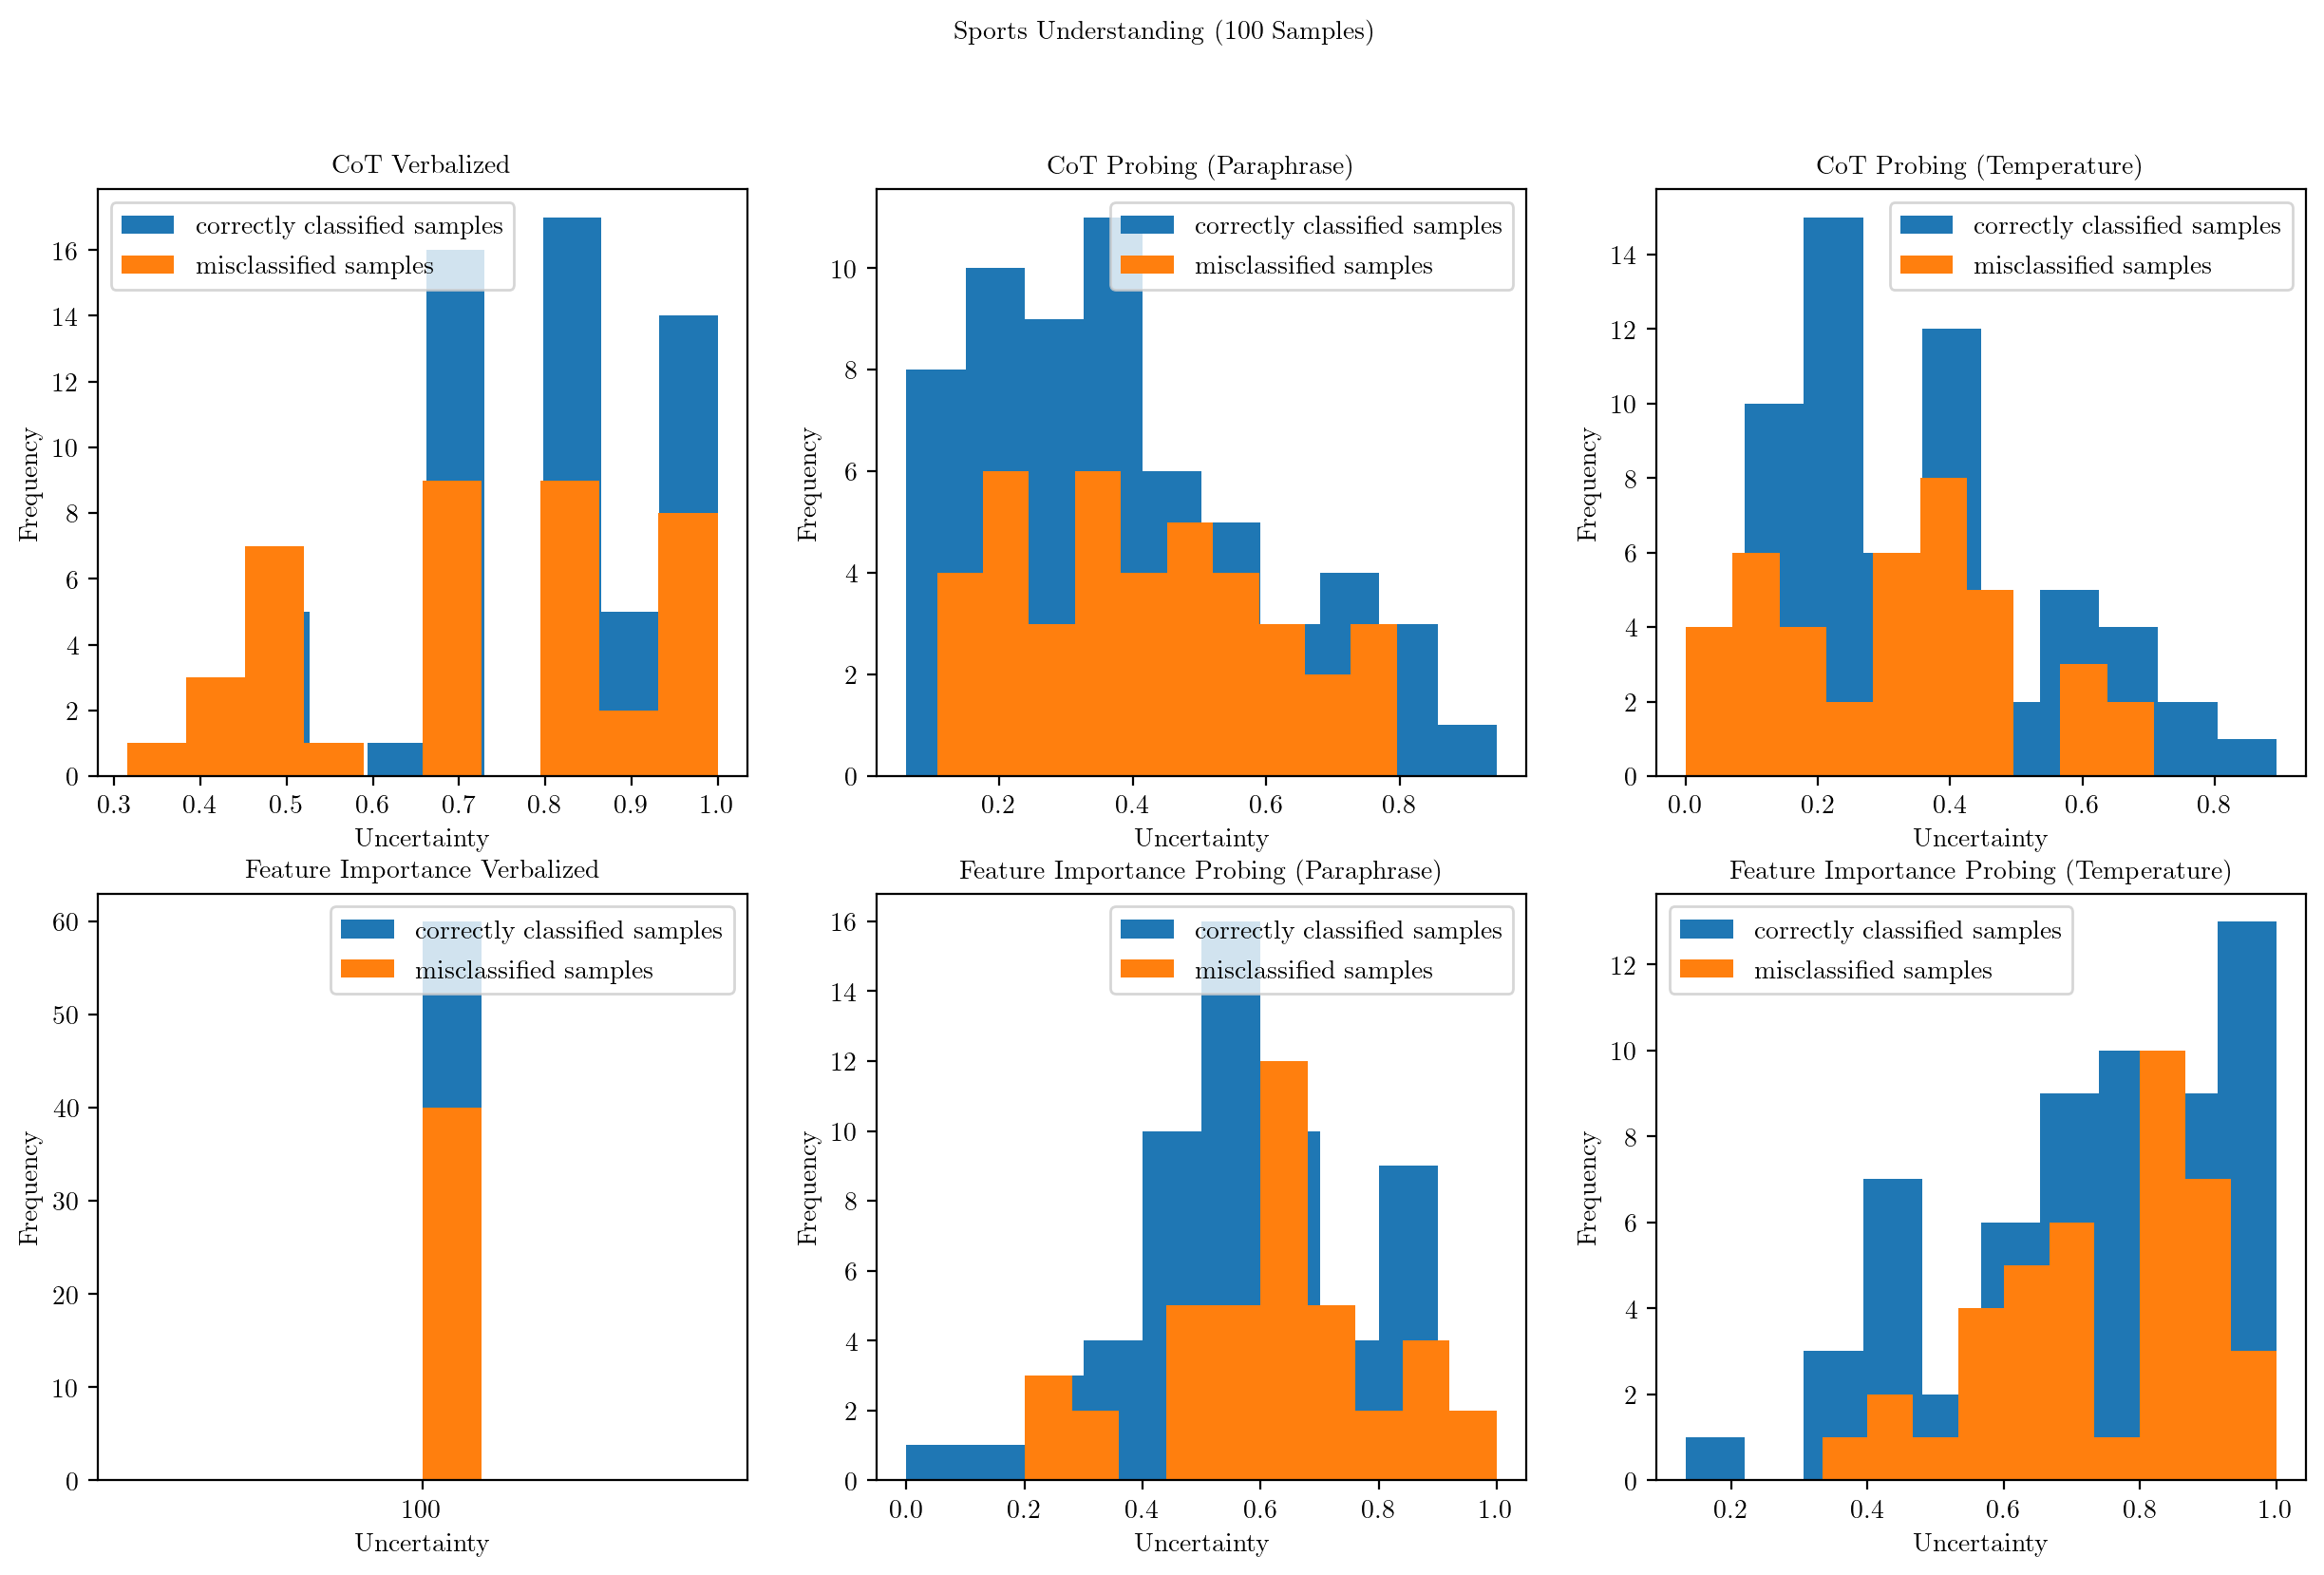

In [26]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

fig, ax = plt.subplots(2, 3, figsize=(15, 9), dpi=200)

for idx, plot_name in enumerate(["CoT", "Feature Importance"]):
    ax[idx][0].set_title(f"{plot_name} Verbalized")
    ax[idx][1].set_title(f"{plot_name} Probing (Paraphrase)")
    ax[idx][2].set_title(f"{plot_name} Probing (Temperature)")

for idx, confidence_column in enumerate(["experiment_1_score", "experiment_4_score", "experiment_8_score"]):
    ax[0][idx].hist(correctly_classified_data[confidence_column], label="correctly classified samples")
    ax[0][idx].hist(misclassified_data[confidence_column], label="misclassified samples")
    ax[0][idx].legend()
    ax[0][idx].set_xlabel("Uncertainty")
    ax[0][idx].set_ylabel("Frequency")
    
for idx, confidence_column in enumerate(["experiment_3_score", "experiment_5_score_overall", "experiment_9_score_overall"]):
    print(confidence_column)
    ax[1][idx].hist(correctly_classified_data[confidence_column], label="correctly classified samples")
    ax[1][idx].hist(misclassified_data[confidence_column], label="misclassified samples")
    ax[1][idx].legend()
    ax[1][idx].set_xlabel("Uncertainty")
    ax[1][idx].set_ylabel("Frequency")
    
dataset_name = "Sports Understanding (100 Samples)"
fig.suptitle(f'{dataset_name}', fontsize=10)
image_save_path = file_path.replace(".parquet", ".png").replace("output", "plot-hist-")
assert image_save_path != file_path
fig.savefig(image_save_path)


## Plot explanation confidence v/s accuracy

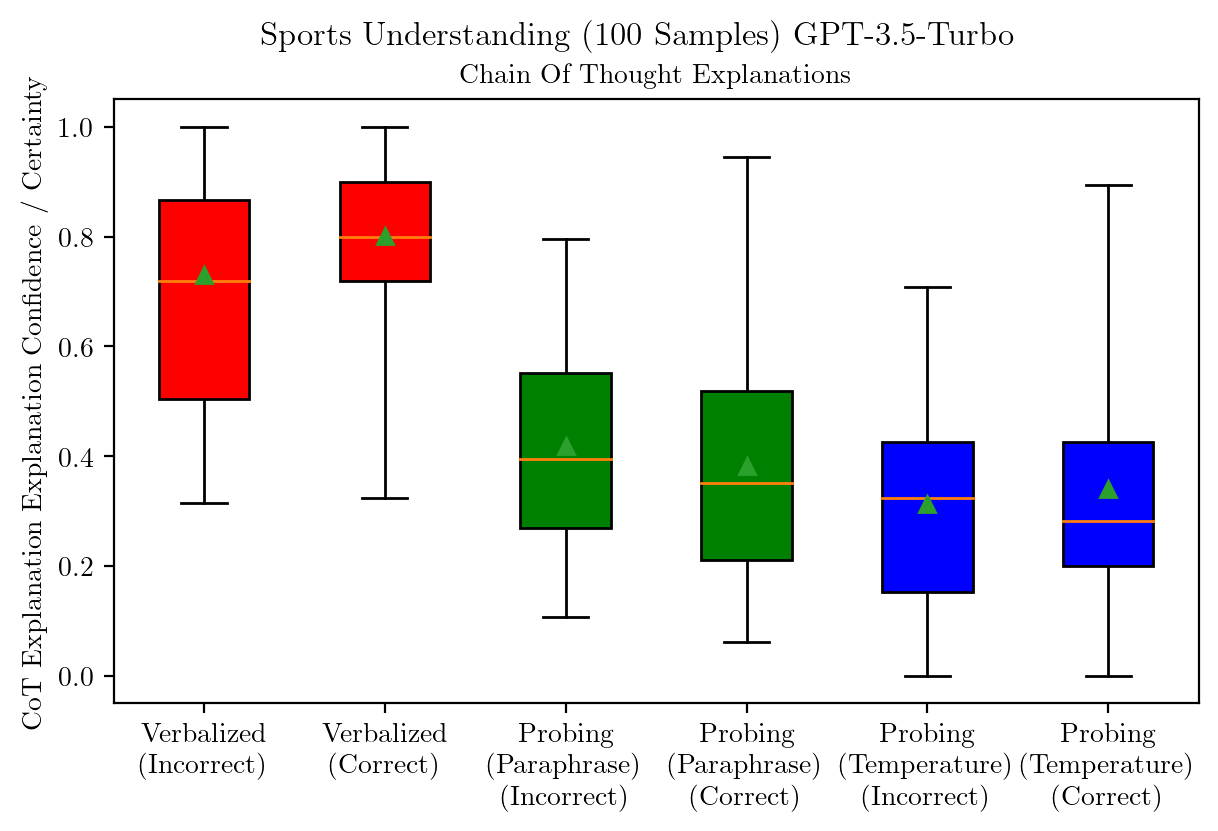

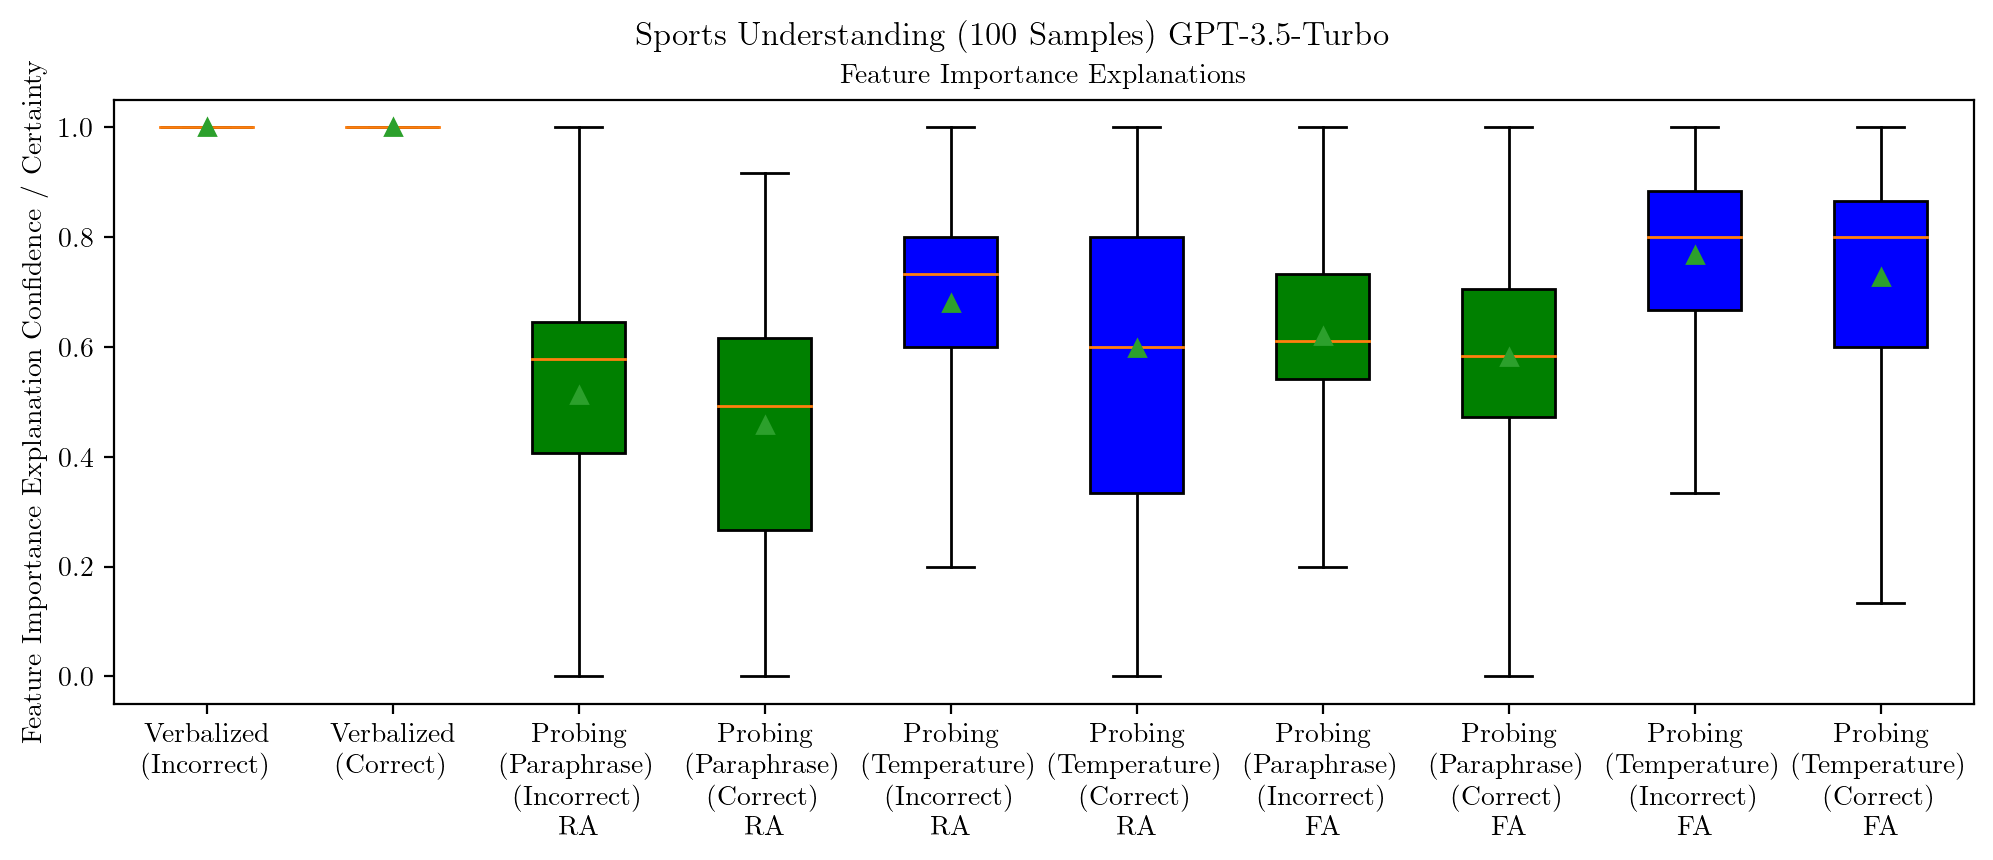

In [27]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

fig_1, ax_1 = plt.subplots(1, 1, figsize=(7, 4), dpi=200)
fig_2, ax_2 = plt.subplots(1, 1, figsize=(12, 4), dpi=200)

plot_data_1 = [
    misclassified_data["experiment_1_score"],
    correctly_classified_data["experiment_1_score"],   
    misclassified_data["experiment_4_score"],
    correctly_classified_data["experiment_4_score"],
    misclassified_data["experiment_8_score"],
    correctly_classified_data["experiment_8_score"],
]
plot_data_2 = [
    misclassified_data["experiment_3_score"].astype(int) / 100.0,
    correctly_classified_data["experiment_3_score"].astype(int) / 100.0, 
    misclassified_data["experiment_5_score_rank"],
    correctly_classified_data["experiment_5_score_rank"],
    misclassified_data["experiment_9_score_rank"],
    correctly_classified_data["experiment_9_score_rank"],
    misclassified_data["experiment_5_score_overall"],
    correctly_classified_data["experiment_5_score_overall"],
    misclassified_data["experiment_9_score_overall"],
    correctly_classified_data["experiment_9_score_overall"],
]
labels_1 = [
    'Verbalized\n(Incorrect)', 
    'Verbalized\n(Correct)',
    'Probing\n(Paraphrase)\n(Incorrect)', 
    'Probing\n(Paraphrase)\n(Correct)', 
    'Probing\n(Temperature)\n(Incorrect)', 
    'Probing\n(Temperature)\n(Correct)', 
]
labels_2 = [
    'Verbalized\n(Incorrect)', 
    'Verbalized\n(Correct)',
    'Probing\n(Paraphrase)\n(Incorrect)\nRA', 
    'Probing\n(Paraphrase)\n(Correct)\nRA', 
    'Probing\n(Temperature)\n(Incorrect)\nRA', 
    'Probing\n(Temperature)\n(Correct)\nRA', 
    'Probing\n(Paraphrase)\n(Incorrect)\nFA', 
    'Probing\n(Paraphrase)\n(Correct)\nFA', 
    'Probing\n(Temperature)\n(Incorrect)\nFA', 
    'Probing\n(Temperature)\n(Correct)\nFA', 
]
boxes_1 = []
for _label, _data in zip(labels_1, plot_data_1):
    boxes_1.append(
        {
            'label' : _label,
            'whislo': _data.min(),             # Bottom whisker position
            'q1'    : _data.quantile(0.25),    # First quartile (25th percentile)
            'med'   : _data.quantile(0.50),    # Median         (50th percentile)
            'mean'  : _data.mean(),            # Mean
            'q3'    : _data.quantile(0.75),    # Third quartile (75th percentile)
            'whishi': _data.max(),             # Top whisker position
            'fliers': [],                      # Outliers
        })
boxplot = ax_1.bxp(boxes_1, showfliers=True, showmeans=True, patch_artist = True)
for box, color in zip(boxplot['boxes'], ["red", "red", "green", "green", "blue", "blue"]):
    box.set(facecolor=color)
ax_1.set_ylabel('CoT Explanation Explanation Confidence / Certainty')
ax_1.set_title('Chain Of Thought Explanations')

boxes_2 = []
for _label, _data in zip(labels_2, plot_data_2):
    _data = _data.astype(float)
    boxes_2.append(
        {
            'label' : _label,
            'whislo': _data.min(),             # Bottom whisker position
            'q1'    : _data.quantile(0.25),    # First quartile (25th percentile)
            'med'   : _data.quantile(0.50),    # Median         (50th percentile)
            'mean'  : _data.mean(),            # Mean
            'q3'    : _data.quantile(0.75),    # Third quartile (75th percentile)
            'whishi': _data.max(),             # Top whisker position
            'fliers': [],                      # Outliers
        })
boxplot = ax_2.bxp(boxes_2, showfliers=True, showmeans=True, patch_artist = True, boxprops = dict(facecolor = "lightblue"))
for box, color in zip(boxplot['boxes'], ["red", "red", "green", "green", "blue", "blue", "green", "green", "blue", "blue", "blue"]):
    box.set(facecolor=color)
ax_2.set_ylabel('Feature Importance Explanation Confidence / Certainty')
ax_2.set_title('Feature Importance Explanations')
# ax_2.set_yscale('log')

dataset_name = "Sports Understanding (100 Samples) GPT-3.5-Turbo"
fig_1.suptitle(f'{dataset_name}')
fig_2.suptitle(f'{dataset_name}')

image_save_path = file_path.replace(".parquet", ".png").replace("output", "plot-cot-accuracy-explanation-confidence")
fig_1.savefig(image_save_path)
image_save_path = file_path.replace(".parquet", ".png").replace("output", "plot-fi-accuracy-explanation-confidence")
fig_2.savefig(image_save_path)

## Plot correlation matrix of verbalized, sample probing and model probing uncertainty metrics

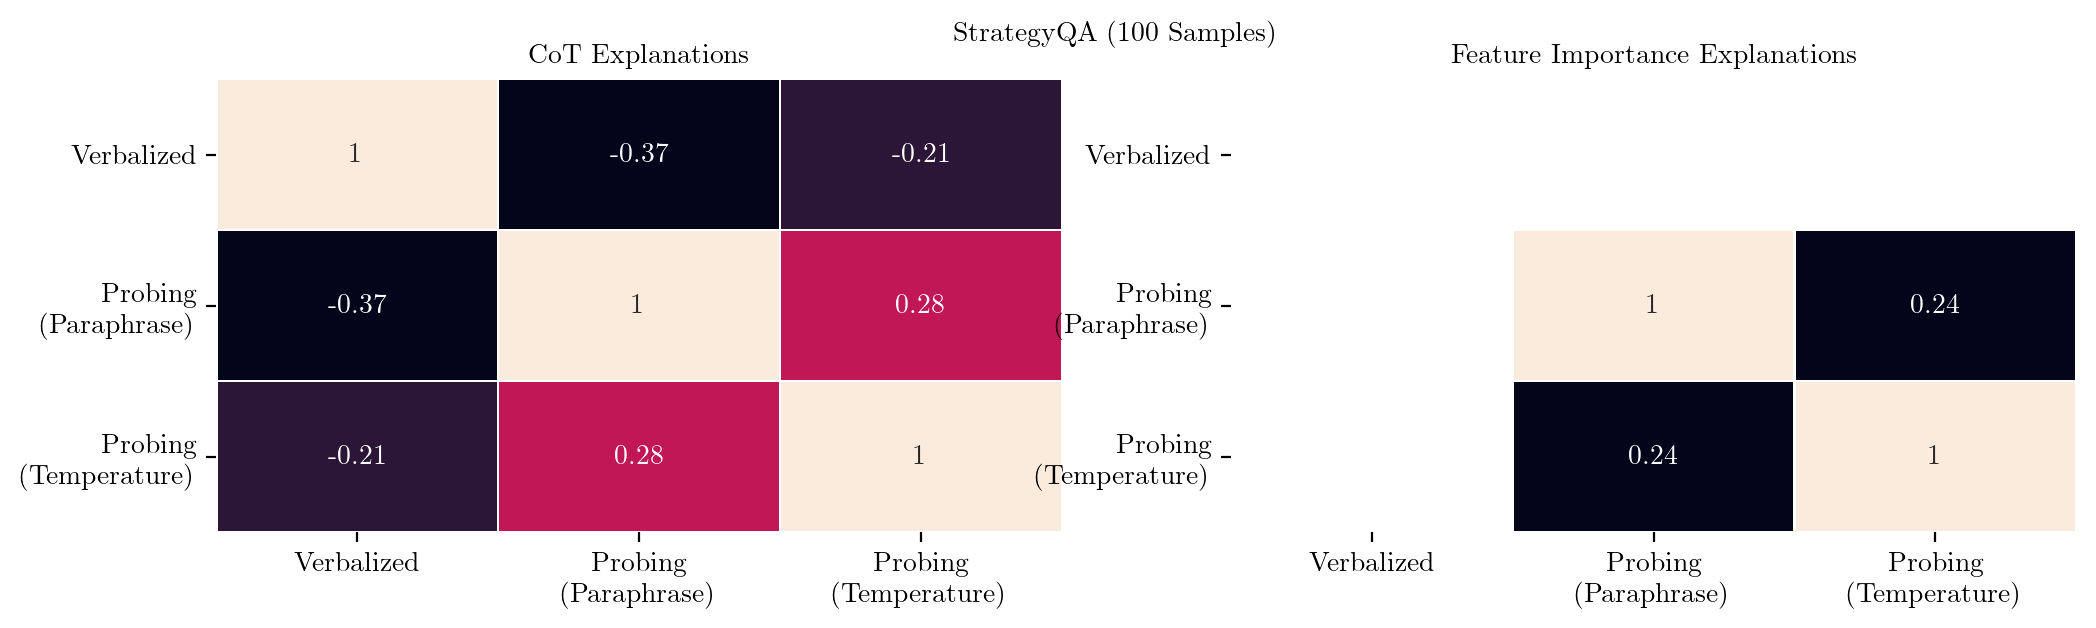

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate sample data (replace with your actual data)
corr_data_1 = {
    "Verbalized": data['experiment_1_score'],
    "Probing\n(Paraphrase)": data['experiment_4_score'],
    "Probing\n(Temperature)": data['experiment_8_score'],
}

corr_data_2 = {
    "Verbalized": data['experiment_3_score'],
    "Probing\n(Paraphrase)": data['experiment_5_score_rank'],
    "Probing\n(Temperature)": data['experiment_9_score_rank'],
}

# Create a DataFrame from the data (you can use your own data)
import pandas as pd
df_1 = pd.DataFrame(corr_data_1)
df_2 = pd.DataFrame(corr_data_2)

# Calculate the correlation matrix
corr_matrix_1 = df_1.corr()
corr_matrix_2 = df_2.corr()

# Create a heatmap plot
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=200)

dataset_name = "StrategyQA (100 Samples)"
fig.suptitle(f'{dataset_name}', fontsize=10)

sns.heatmap(corr_matrix_1, annot=True, linewidths=0.5, ax=ax[0], cbar=False)
sns.heatmap(corr_matrix_2, annot=True, linewidths=0.5, ax=ax[1], cbar=False)
ax[0].set_title("CoT Explanations")
ax[1].set_title("Feature Importance Explanations")
image_save_path = file_path.replace(".parquet", ".png").replace("output", "plot-confusion-matrix")
assert image_save_path != file_path
fig.savefig(image_save_path)


## Save

In [30]:
save_path = file_path.replace("output-", "scores-")
assert save_path != file_path
import os
assert os.path.exists(save_path) is False
data.to_parquet(save_path)

# The End